# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

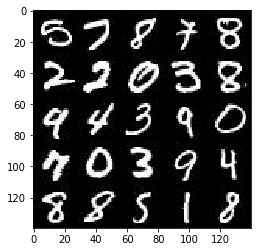

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

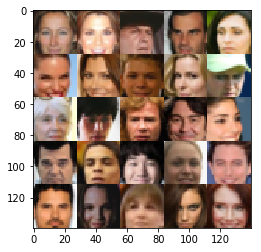

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    real_inputs = tf.placeholder( tf.float32, (None, image_width, image_height, image_channels), name='real_inputs')
    z_inputs    = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    lr = tf.placeholder(tf.float32, (None), name='learn_rate')

    return (real_inputs, z_inputs, lr)



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha = 0.05
    
    with tf.variable_scope('discriminator', reuse=reuse):
       
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
       
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
      
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=1, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
      
        flat = tf.reshape(relu3, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        
        return output, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.05
    
    with tf.variable_scope('generator', reuse=not is_train):
       
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
       
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
      
        output = tf.tanh(logits)
        
        return output
    




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
   
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_every = 10
    show_every = 100
    steps = 0
    
    samples, width, height, channels = data_shape
    
    real_inputs, z_inputs, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(real_inputs, z_inputs, channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0

                # Run optimizers
                sess.run(d_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z,
                                                 learn_rate: learning_rate})
                sess.run(g_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z,
                                                 learn_rate: learning_rate})
                sess.run(g_train_opt, feed_dict={real_inputs: batch_images, z_inputs: batch_z,
                                                 learn_rate: learning_rate})
                
                steps += 1
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({real_inputs: batch_images, z_inputs: batch_z})
                    train_loss_g = g_loss.eval({real_inputs: batch_images, z_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, z_inputs, channels, data_image_mode)
          

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4280... Generator Loss: 49.4877
Epoch 1/2... Discriminator Loss: 0.0915... Generator Loss: 3.2198
Epoch 1/2... Discriminator Loss: 14.4537... Generator Loss: 48.9813
Epoch 1/2... Discriminator Loss: 0.4485... Generator Loss: 4.6294
Epoch 1/2... Discriminator Loss: 1.0329... Generator Loss: 3.0650
Epoch 1/2... Discriminator Loss: 0.0913... Generator Loss: 4.4107
Epoch 1/2... Discriminator Loss: 0.0435... Generator Loss: 4.4694
Epoch 1/2... Discriminator Loss: 0.0030... Generator Loss: 6.0961
Epoch 1/2... Discriminator Loss: 0.0050... Generator Loss: 5.7377
Epoch 1/2... Discriminator Loss: 0.7977... Generator Loss: 4.2037


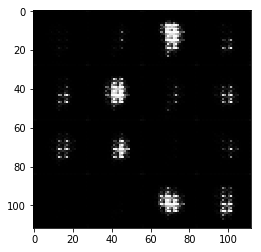

Epoch 1/2... Discriminator Loss: 0.5191... Generator Loss: 1.4008
Epoch 1/2... Discriminator Loss: 0.4991... Generator Loss: 2.3231
Epoch 1/2... Discriminator Loss: 1.2652... Generator Loss: 3.2586
Epoch 1/2... Discriminator Loss: 1.2586... Generator Loss: 1.9436
Epoch 1/2... Discriminator Loss: 1.8541... Generator Loss: 2.2210
Epoch 1/2... Discriminator Loss: 2.6271... Generator Loss: 0.2128
Epoch 1/2... Discriminator Loss: 2.1672... Generator Loss: 1.4518
Epoch 1/2... Discriminator Loss: 1.7618... Generator Loss: 0.7369
Epoch 1/2... Discriminator Loss: 0.6488... Generator Loss: 1.0300
Epoch 1/2... Discriminator Loss: 1.4359... Generator Loss: 0.7994


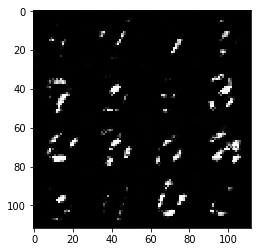

Epoch 1/2... Discriminator Loss: 1.8507... Generator Loss: 1.8651
Epoch 1/2... Discriminator Loss: 1.6861... Generator Loss: 0.7966
Epoch 1/2... Discriminator Loss: 1.9434... Generator Loss: 0.3110
Epoch 1/2... Discriminator Loss: 1.5031... Generator Loss: 1.7859
Epoch 1/2... Discriminator Loss: 1.4736... Generator Loss: 0.9447
Epoch 1/2... Discriminator Loss: 1.5897... Generator Loss: 0.5160
Epoch 1/2... Discriminator Loss: 1.5011... Generator Loss: 0.9911
Epoch 1/2... Discriminator Loss: 2.1201... Generator Loss: 0.1988
Epoch 1/2... Discriminator Loss: 1.8790... Generator Loss: 0.2558
Epoch 1/2... Discriminator Loss: 1.8734... Generator Loss: 0.3004


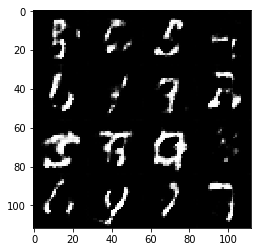

Epoch 1/2... Discriminator Loss: 2.0349... Generator Loss: 1.7265
Epoch 1/2... Discriminator Loss: 1.4847... Generator Loss: 0.4942
Epoch 1/2... Discriminator Loss: 1.2842... Generator Loss: 0.6971
Epoch 1/2... Discriminator Loss: 1.8495... Generator Loss: 2.5798
Epoch 1/2... Discriminator Loss: 1.2814... Generator Loss: 1.1573
Epoch 1/2... Discriminator Loss: 1.8065... Generator Loss: 2.6694
Epoch 1/2... Discriminator Loss: 1.5981... Generator Loss: 0.3392
Epoch 1/2... Discriminator Loss: 2.4163... Generator Loss: 5.3003
Epoch 1/2... Discriminator Loss: 1.8307... Generator Loss: 0.2873
Epoch 1/2... Discriminator Loss: 1.5717... Generator Loss: 1.9063


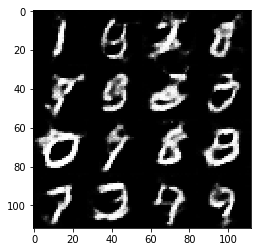

Epoch 1/2... Discriminator Loss: 1.4118... Generator Loss: 0.5815
Epoch 1/2... Discriminator Loss: 1.4226... Generator Loss: 0.6865
Epoch 1/2... Discriminator Loss: 1.6386... Generator Loss: 1.6137
Epoch 1/2... Discriminator Loss: 1.4374... Generator Loss: 0.8433
Epoch 1/2... Discriminator Loss: 1.4938... Generator Loss: 0.7217
Epoch 1/2... Discriminator Loss: 1.3030... Generator Loss: 0.8635
Epoch 1/2... Discriminator Loss: 1.4934... Generator Loss: 0.6193
Epoch 1/2... Discriminator Loss: 2.1271... Generator Loss: 0.1917
Epoch 1/2... Discriminator Loss: 1.6278... Generator Loss: 0.3847
Epoch 1/2... Discriminator Loss: 1.6253... Generator Loss: 0.3584


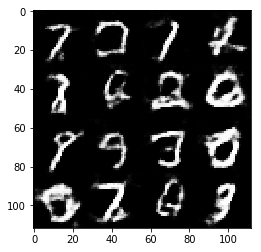

Epoch 1/2... Discriminator Loss: 1.3087... Generator Loss: 0.6185
Epoch 1/2... Discriminator Loss: 1.3950... Generator Loss: 0.6494
Epoch 1/2... Discriminator Loss: 1.5866... Generator Loss: 1.0624
Epoch 1/2... Discriminator Loss: 1.3829... Generator Loss: 0.7107
Epoch 1/2... Discriminator Loss: 1.5218... Generator Loss: 0.6988
Epoch 1/2... Discriminator Loss: 1.5237... Generator Loss: 0.4865
Epoch 1/2... Discriminator Loss: 1.9744... Generator Loss: 0.2053
Epoch 1/2... Discriminator Loss: 1.3626... Generator Loss: 0.9210
Epoch 1/2... Discriminator Loss: 1.4832... Generator Loss: 0.8111
Epoch 1/2... Discriminator Loss: 2.1432... Generator Loss: 0.1699


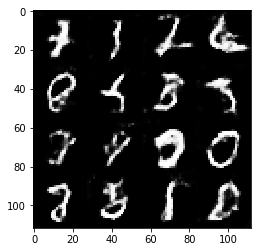

Epoch 1/2... Discriminator Loss: 1.6810... Generator Loss: 0.3712
Epoch 1/2... Discriminator Loss: 1.5800... Generator Loss: 0.8002
Epoch 1/2... Discriminator Loss: 1.4128... Generator Loss: 0.9004
Epoch 1/2... Discriminator Loss: 1.7030... Generator Loss: 0.3066
Epoch 1/2... Discriminator Loss: 1.7462... Generator Loss: 1.2023
Epoch 1/2... Discriminator Loss: 2.0819... Generator Loss: 0.1840
Epoch 1/2... Discriminator Loss: 1.7408... Generator Loss: 1.0676
Epoch 1/2... Discriminator Loss: 1.4962... Generator Loss: 0.9379
Epoch 1/2... Discriminator Loss: 1.5819... Generator Loss: 0.3829
Epoch 1/2... Discriminator Loss: 1.5506... Generator Loss: 0.3880


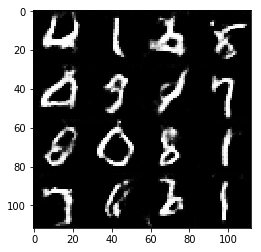

Epoch 1/2... Discriminator Loss: 2.0204... Generator Loss: 0.2038
Epoch 1/2... Discriminator Loss: 1.7292... Generator Loss: 1.1920
Epoch 1/2... Discriminator Loss: 2.1334... Generator Loss: 0.1663
Epoch 1/2... Discriminator Loss: 1.4009... Generator Loss: 0.6719
Epoch 1/2... Discriminator Loss: 1.6010... Generator Loss: 0.3941
Epoch 1/2... Discriminator Loss: 1.8043... Generator Loss: 0.6804
Epoch 1/2... Discriminator Loss: 1.7938... Generator Loss: 0.2669
Epoch 1/2... Discriminator Loss: 1.7352... Generator Loss: 0.2832
Epoch 1/2... Discriminator Loss: 1.7514... Generator Loss: 0.3220
Epoch 1/2... Discriminator Loss: 1.4095... Generator Loss: 0.6730


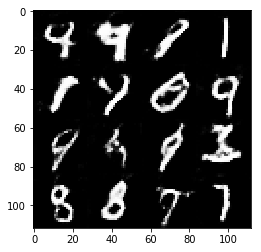

Epoch 1/2... Discriminator Loss: 2.1812... Generator Loss: 0.1480
Epoch 1/2... Discriminator Loss: 1.5720... Generator Loss: 0.4174
Epoch 1/2... Discriminator Loss: 1.4866... Generator Loss: 1.4408
Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 1.1992
Epoch 1/2... Discriminator Loss: 1.4591... Generator Loss: 1.1965
Epoch 1/2... Discriminator Loss: 1.8723... Generator Loss: 1.8721
Epoch 1/2... Discriminator Loss: 1.3424... Generator Loss: 0.9903
Epoch 1/2... Discriminator Loss: 1.4373... Generator Loss: 1.0884
Epoch 1/2... Discriminator Loss: 1.5538... Generator Loss: 0.9158
Epoch 1/2... Discriminator Loss: 1.4866... Generator Loss: 0.4660


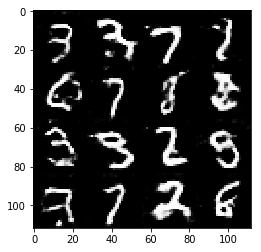

Epoch 1/2... Discriminator Loss: 2.0806... Generator Loss: 0.1767
Epoch 1/2... Discriminator Loss: 1.4044... Generator Loss: 1.0521
Epoch 1/2... Discriminator Loss: 1.4812... Generator Loss: 0.8260
Epoch 2/2... Discriminator Loss: 1.5124... Generator Loss: 0.8624
Epoch 2/2... Discriminator Loss: 2.7597... Generator Loss: 0.0828
Epoch 2/2... Discriminator Loss: 2.4020... Generator Loss: 0.1174
Epoch 2/2... Discriminator Loss: 1.9094... Generator Loss: 0.2177
Epoch 2/2... Discriminator Loss: 1.5829... Generator Loss: 0.8022
Epoch 2/2... Discriminator Loss: 1.7483... Generator Loss: 0.8085
Epoch 2/2... Discriminator Loss: 1.4606... Generator Loss: 0.5262


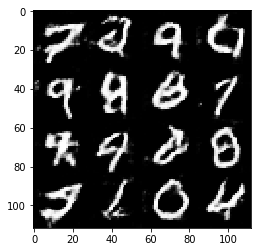

Epoch 2/2... Discriminator Loss: 2.1893... Generator Loss: 0.1529
Epoch 2/2... Discriminator Loss: 1.3990... Generator Loss: 1.2324
Epoch 2/2... Discriminator Loss: 1.7133... Generator Loss: 0.2946
Epoch 2/2... Discriminator Loss: 1.9826... Generator Loss: 0.2214
Epoch 2/2... Discriminator Loss: 1.4362... Generator Loss: 0.4328
Epoch 2/2... Discriminator Loss: 1.7049... Generator Loss: 0.2986
Epoch 2/2... Discriminator Loss: 2.0082... Generator Loss: 0.2289
Epoch 2/2... Discriminator Loss: 1.7455... Generator Loss: 0.3621
Epoch 2/2... Discriminator Loss: 1.7926... Generator Loss: 0.2958
Epoch 2/2... Discriminator Loss: 2.2316... Generator Loss: 0.1622


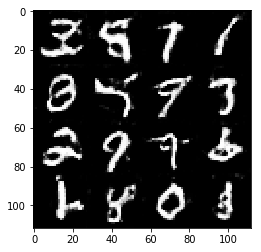

Epoch 2/2... Discriminator Loss: 1.6337... Generator Loss: 0.3666
Epoch 2/2... Discriminator Loss: 1.5372... Generator Loss: 0.4087
Epoch 2/2... Discriminator Loss: 1.5009... Generator Loss: 0.7337
Epoch 2/2... Discriminator Loss: 1.5792... Generator Loss: 0.5762
Epoch 2/2... Discriminator Loss: 1.4893... Generator Loss: 0.5108
Epoch 2/2... Discriminator Loss: 1.4081... Generator Loss: 0.9181
Epoch 2/2... Discriminator Loss: 1.8720... Generator Loss: 0.2598
Epoch 2/2... Discriminator Loss: 2.1759... Generator Loss: 0.1748
Epoch 2/2... Discriminator Loss: 1.0946... Generator Loss: 0.8422
Epoch 2/2... Discriminator Loss: 2.2864... Generator Loss: 0.1638


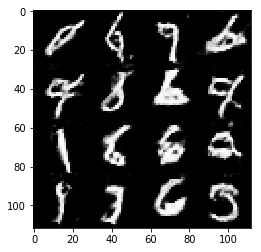

Epoch 2/2... Discriminator Loss: 1.3938... Generator Loss: 0.6144
Epoch 2/2... Discriminator Loss: 1.5960... Generator Loss: 0.3290
Epoch 2/2... Discriminator Loss: 1.2732... Generator Loss: 0.7818
Epoch 2/2... Discriminator Loss: 2.0299... Generator Loss: 0.2107
Epoch 2/2... Discriminator Loss: 1.2760... Generator Loss: 0.8150
Epoch 2/2... Discriminator Loss: 1.6327... Generator Loss: 0.3343
Epoch 2/2... Discriminator Loss: 1.2541... Generator Loss: 0.9770
Epoch 2/2... Discriminator Loss: 1.9428... Generator Loss: 0.2058
Epoch 2/2... Discriminator Loss: 2.3346... Generator Loss: 0.1382
Epoch 2/2... Discriminator Loss: 1.8742... Generator Loss: 0.2253


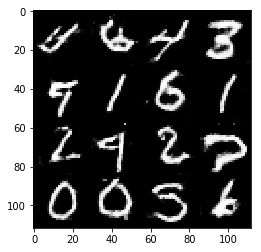

Epoch 2/2... Discriminator Loss: 1.9830... Generator Loss: 0.1945
Epoch 2/2... Discriminator Loss: 1.9625... Generator Loss: 0.2790
Epoch 2/2... Discriminator Loss: 1.4265... Generator Loss: 1.0973
Epoch 2/2... Discriminator Loss: 1.7295... Generator Loss: 0.2840
Epoch 2/2... Discriminator Loss: 1.6382... Generator Loss: 0.3733
Epoch 2/2... Discriminator Loss: 1.3230... Generator Loss: 0.8558
Epoch 2/2... Discriminator Loss: 1.5715... Generator Loss: 0.3988
Epoch 2/2... Discriminator Loss: 1.3613... Generator Loss: 1.0952
Epoch 2/2... Discriminator Loss: 1.4558... Generator Loss: 0.6657
Epoch 2/2... Discriminator Loss: 1.4533... Generator Loss: 0.4357


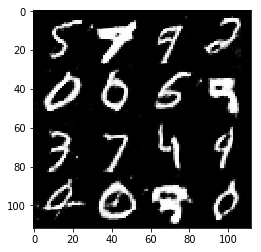

Epoch 2/2... Discriminator Loss: 1.3790... Generator Loss: 0.6172
Epoch 2/2... Discriminator Loss: 1.4376... Generator Loss: 0.8768
Epoch 2/2... Discriminator Loss: 1.1014... Generator Loss: 0.8827
Epoch 2/2... Discriminator Loss: 1.7721... Generator Loss: 2.3771
Epoch 2/2... Discriminator Loss: 1.9173... Generator Loss: 0.2499
Epoch 2/2... Discriminator Loss: 1.6133... Generator Loss: 1.0081
Epoch 2/2... Discriminator Loss: 1.2340... Generator Loss: 0.6771
Epoch 2/2... Discriminator Loss: 2.4852... Generator Loss: 0.1221
Epoch 2/2... Discriminator Loss: 1.1815... Generator Loss: 1.3055
Epoch 2/2... Discriminator Loss: 1.4927... Generator Loss: 1.3012


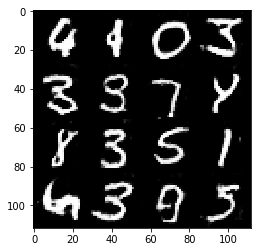

Epoch 2/2... Discriminator Loss: 1.4278... Generator Loss: 1.4083
Epoch 2/2... Discriminator Loss: 2.4248... Generator Loss: 1.9741
Epoch 2/2... Discriminator Loss: 1.3312... Generator Loss: 0.6870
Epoch 2/2... Discriminator Loss: 1.8610... Generator Loss: 0.2593
Epoch 2/2... Discriminator Loss: 1.6485... Generator Loss: 0.3451
Epoch 2/2... Discriminator Loss: 3.0261... Generator Loss: 0.0655
Epoch 2/2... Discriminator Loss: 1.3311... Generator Loss: 0.6578
Epoch 2/2... Discriminator Loss: 1.5438... Generator Loss: 0.3964
Epoch 2/2... Discriminator Loss: 2.6762... Generator Loss: 0.1065
Epoch 2/2... Discriminator Loss: 1.7065... Generator Loss: 0.2819


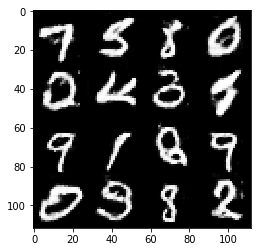

Epoch 2/2... Discriminator Loss: 1.4291... Generator Loss: 1.1441
Epoch 2/2... Discriminator Loss: 2.2452... Generator Loss: 0.1532
Epoch 2/2... Discriminator Loss: 1.8345... Generator Loss: 0.2863
Epoch 2/2... Discriminator Loss: 2.2904... Generator Loss: 0.1714
Epoch 2/2... Discriminator Loss: 1.3051... Generator Loss: 0.6835
Epoch 2/2... Discriminator Loss: 1.4809... Generator Loss: 0.8455
Epoch 2/2... Discriminator Loss: 1.1652... Generator Loss: 1.0026
Epoch 2/2... Discriminator Loss: 2.6208... Generator Loss: 0.1084
Epoch 2/2... Discriminator Loss: 1.5857... Generator Loss: 0.9871
Epoch 2/2... Discriminator Loss: 1.2679... Generator Loss: 1.4596


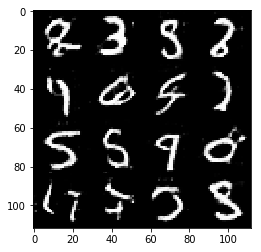

Epoch 2/2... Discriminator Loss: 1.2737... Generator Loss: 0.6395
Epoch 2/2... Discriminator Loss: 1.2748... Generator Loss: 1.5354
Epoch 2/2... Discriminator Loss: 1.3139... Generator Loss: 0.7830
Epoch 2/2... Discriminator Loss: 1.6468... Generator Loss: 0.9081
Epoch 2/2... Discriminator Loss: 1.5893... Generator Loss: 0.3433
Epoch 2/2... Discriminator Loss: 1.5539... Generator Loss: 0.4196
Epoch 2/2... Discriminator Loss: 1.2271... Generator Loss: 1.0413
Epoch 2/2... Discriminator Loss: 1.3940... Generator Loss: 1.1478
Epoch 2/2... Discriminator Loss: 0.9457... Generator Loss: 0.8826
Epoch 2/2... Discriminator Loss: 1.3055... Generator Loss: 0.7647


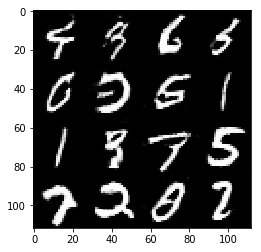

Epoch 2/2... Discriminator Loss: 2.0558... Generator Loss: 1.5808
Epoch 2/2... Discriminator Loss: 1.4880... Generator Loss: 0.9358
Epoch 2/2... Discriminator Loss: 1.0536... Generator Loss: 0.8314
Epoch 2/2... Discriminator Loss: 1.8355... Generator Loss: 0.2420
Epoch 2/2... Discriminator Loss: 0.9715... Generator Loss: 1.2608
Epoch 2/2... Discriminator Loss: 1.8894... Generator Loss: 0.2497
Epoch 2/2... Discriminator Loss: 1.5084... Generator Loss: 0.3580


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 47.7951
Epoch 1/1... Discriminator Loss: 2.2774... Generator Loss: 43.4869
Epoch 1/1... Discriminator Loss: 0.6836... Generator Loss: 5.1196
Epoch 1/1... Discriminator Loss: 0.2611... Generator Loss: 16.0407
Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 2.2721
Epoch 1/1... Discriminator Loss: 3.3483... Generator Loss: 0.1017
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 1.5390
Epoch 1/1... Discriminator Loss: 5.1486... Generator Loss: 9.4918
Epoch 1/1... Discriminator Loss: 3.1496... Generator Loss: 9.5672
Epoch 1/1... Discriminator Loss: 2.2323... Generator Loss: 0.2089


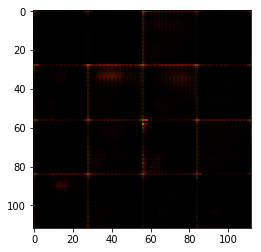

Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.4130
Epoch 1/1... Discriminator Loss: 2.3037... Generator Loss: 0.2008
Epoch 1/1... Discriminator Loss: 1.7183... Generator Loss: 0.6367
Epoch 1/1... Discriminator Loss: 1.9905... Generator Loss: 0.3813
Epoch 1/1... Discriminator Loss: 1.7018... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.7235... Generator Loss: 0.3946
Epoch 1/1... Discriminator Loss: 1.6172... Generator Loss: 0.4894
Epoch 1/1... Discriminator Loss: 1.6166... Generator Loss: 0.5433
Epoch 1/1... Discriminator Loss: 1.7279... Generator Loss: 0.5779
Epoch 1/1... Discriminator Loss: 1.9689... Generator Loss: 1.1951


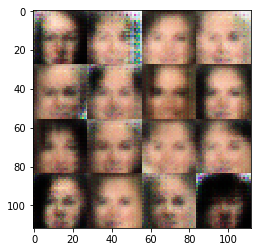

Epoch 1/1... Discriminator Loss: 1.5398... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.6097... Generator Loss: 1.0077
Epoch 1/1... Discriminator Loss: 1.8024... Generator Loss: 1.3729
Epoch 1/1... Discriminator Loss: 1.6422... Generator Loss: 0.5037
Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.5929
Epoch 1/1... Discriminator Loss: 1.7403... Generator Loss: 0.8846
Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.6872... Generator Loss: 0.5022
Epoch 1/1... Discriminator Loss: 1.4693... Generator Loss: 1.1297
Epoch 1/1... Discriminator Loss: 1.6698... Generator Loss: 0.9946


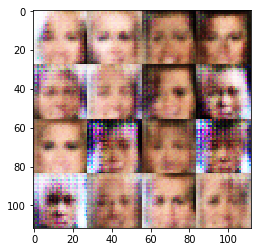

Epoch 1/1... Discriminator Loss: 2.0083... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.9722... Generator Loss: 0.2561
Epoch 1/1... Discriminator Loss: 1.6783... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.5726... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.7462... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.7060... Generator Loss: 0.3419
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.6629... Generator Loss: 0.4608
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.5524
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.5938


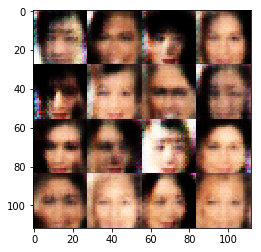

Epoch 1/1... Discriminator Loss: 1.6561... Generator Loss: 0.4738
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 0.4815
Epoch 1/1... Discriminator Loss: 1.6446... Generator Loss: 0.3868
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.7943... Generator Loss: 0.3615
Epoch 1/1... Discriminator Loss: 1.6229... Generator Loss: 0.4817
Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 1.0463
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.5780


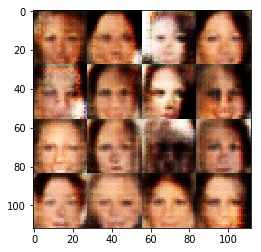

Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.5203... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.6069... Generator Loss: 0.4363
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.5376... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.5585... Generator Loss: 0.8784
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.8641


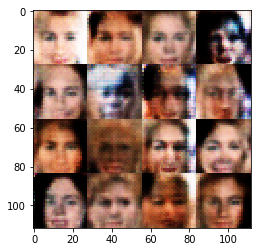

Epoch 1/1... Discriminator Loss: 1.5863... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.6186... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.6828... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.3989
Epoch 1/1... Discriminator Loss: 1.7677... Generator Loss: 0.2609
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 1.0269
Epoch 1/1... Discriminator Loss: 1.7164... Generator Loss: 0.2691
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.6936


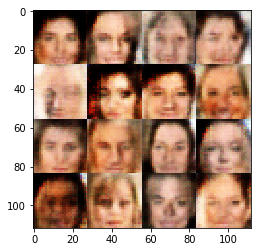

Epoch 1/1... Discriminator Loss: 1.6304... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 1.0083
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.8759... Generator Loss: 0.4651
Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.4354
Epoch 1/1... Discriminator Loss: 1.5077... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.5968... Generator Loss: 0.3634
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.3887


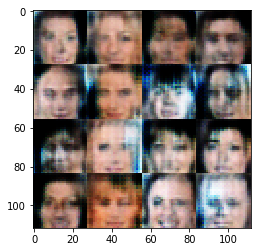

Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 0.5200
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.7087
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.8156... Generator Loss: 1.5352
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.5505
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.9645
Epoch 1/1... Discriminator Loss: 1.7079... Generator Loss: 0.3178
Epoch 1/1... Discriminator Loss: 1.6715... Generator Loss: 1.2424
Epoch 1/1... Discriminator Loss: 1.9036... Generator Loss: 0.3330
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.5352


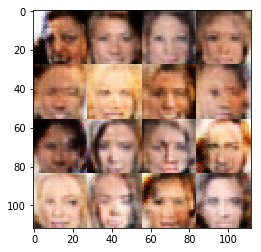

Epoch 1/1... Discriminator Loss: 1.5989... Generator Loss: 0.3476
Epoch 1/1... Discriminator Loss: 1.5896... Generator Loss: 0.3826
Epoch 1/1... Discriminator Loss: 1.5791... Generator Loss: 0.4979
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.9602
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 1.7990
Epoch 1/1... Discriminator Loss: 1.6546... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.7425... Generator Loss: 0.5002
Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.5621


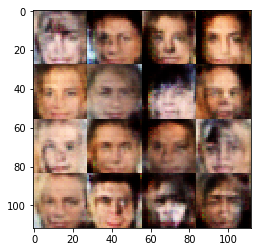

Epoch 1/1... Discriminator Loss: 1.6241... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.5006... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.6236... Generator Loss: 0.4659
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.6119... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.6348... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.5345... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.4803


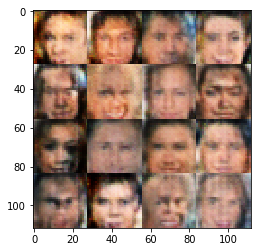

Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.6874... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.5911... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.5330... Generator Loss: 0.4233
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.5474
Epoch 1/1... Discriminator Loss: 1.5120... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.6067... Generator Loss: 1.0872
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 2.3466... Generator Loss: 1.5160


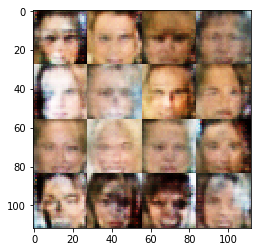

Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.5016
Epoch 1/1... Discriminator Loss: 1.5619... Generator Loss: 0.4607
Epoch 1/1... Discriminator Loss: 1.6656... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.5886... Generator Loss: 0.4905
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.6750
Epoch 1/1... Discriminator Loss: 1.5267... Generator Loss: 0.4244
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.5844... Generator Loss: 0.4613


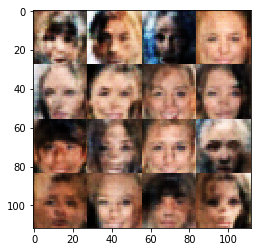

Epoch 1/1... Discriminator Loss: 1.4912... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.5381
Epoch 1/1... Discriminator Loss: 1.5583... Generator Loss: 0.5686
Epoch 1/1... Discriminator Loss: 1.5215... Generator Loss: 0.5389
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 1.0065
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.7746


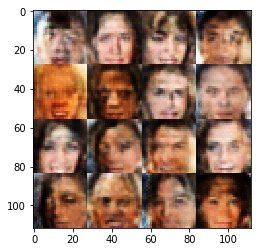

Epoch 1/1... Discriminator Loss: 1.5246... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.8539
Epoch 1/1... Discriminator Loss: 1.5167... Generator Loss: 0.5536
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.5023
Epoch 1/1... Discriminator Loss: 1.5639... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.5021... Generator Loss: 0.7793


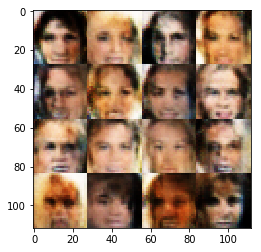

Epoch 1/1... Discriminator Loss: 1.5520... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.4957... Generator Loss: 0.5188
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.7488... Generator Loss: 1.0941
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.5210
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.6345
Epoch 1/1... Discriminator Loss: 1.5389... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.6210


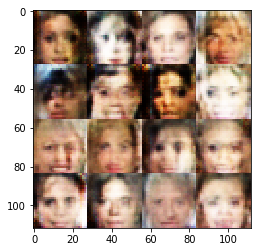

Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.4810
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.6201... Generator Loss: 0.4448
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.8469
Epoch 1/1... Discriminator Loss: 1.6700... Generator Loss: 0.4473
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7663


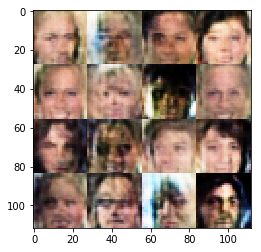

Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.5907
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 0.6554
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.7889... Generator Loss: 0.2848


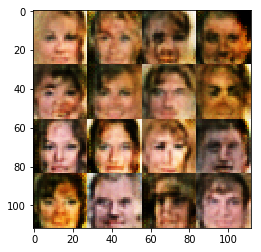

Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.5723... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.4741
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.5131... Generator Loss: 0.5089
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.5022
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.8281


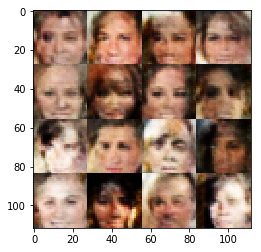

Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.5355... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.4586
Epoch 1/1... Discriminator Loss: 1.8072... Generator Loss: 0.4115
Epoch 1/1... Discriminator Loss: 1.6282... Generator Loss: 0.4486
Epoch 1/1... Discriminator Loss: 1.5721... Generator Loss: 0.4595
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.4926... Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.6250


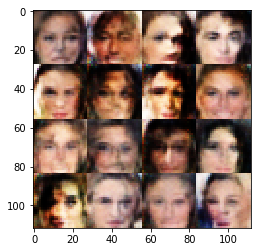

Epoch 1/1... Discriminator Loss: 1.4397... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.5025... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 1.0726
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.6506
Epoch 1/1... Discriminator Loss: 1.6343... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 2.0931... Generator Loss: 0.2951
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 1.0266
Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.8153


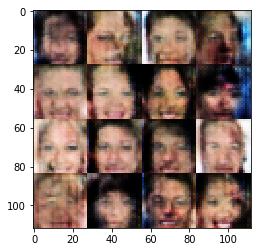

Epoch 1/1... Discriminator Loss: 1.5912... Generator Loss: 0.5811
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.6495... Generator Loss: 0.4204
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.6225... Generator Loss: 0.4658
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.6628


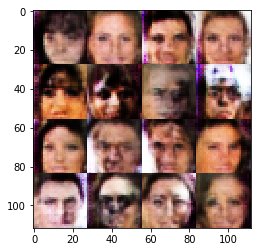

Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 0.7053... Generator Loss: 1.3858
Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 0.9227
Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 0.8070... Generator Loss: 0.9143
Epoch 1/1... Discriminator Loss: 1.5558... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 0.9840... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 0.5282... Generator Loss: 1.6663


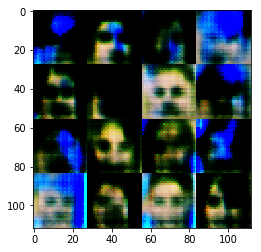

Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 3.4377... Generator Loss: 0.0544
Epoch 1/1... Discriminator Loss: 1.0838... Generator Loss: 1.0364
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 1.0718
Epoch 1/1... Discriminator Loss: 1.5785... Generator Loss: 1.6264
Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 2.0236
Epoch 1/1... Discriminator Loss: 1.5608... Generator Loss: 0.3360
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 1.2142
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.9853


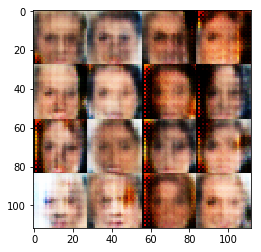

Epoch 1/1... Discriminator Loss: 2.1542... Generator Loss: 0.1895
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.4342
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 0.5309
Epoch 1/1... Discriminator Loss: 1.7386... Generator Loss: 0.2817
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 1.1926
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.4239
Epoch 1/1... Discriminator Loss: 1.5299... Generator Loss: 0.5587
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.5668
Epoch 1/1... Discriminator Loss: 2.0493... Generator Loss: 0.2642


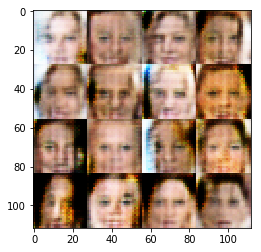

Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 0.8208
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.6233... Generator Loss: 1.0632
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 2.2026... Generator Loss: 0.3061
Epoch 1/1... Discriminator Loss: 1.4320... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.6121
Epoch 1/1... Discriminator Loss: 1.0929... Generator Loss: 1.6245


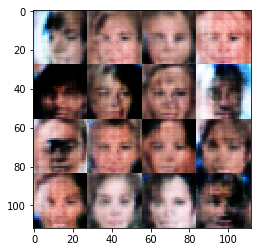

Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.9426
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.0818... Generator Loss: 0.6059
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.8347


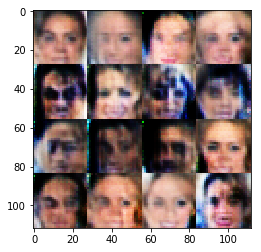

Epoch 1/1... Discriminator Loss: 1.5579... Generator Loss: 0.5380
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 1.1968
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.9212
Epoch 1/1... Discriminator Loss: 0.7648... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.5755
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.6718


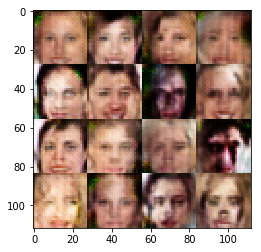

Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.6659... Generator Loss: 0.2802
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.5792
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.5079
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 0.4817


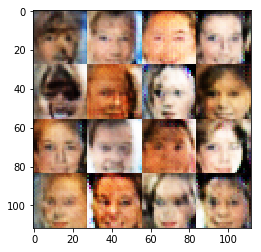

Epoch 1/1... Discriminator Loss: 1.4614... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.4835
Epoch 1/1... Discriminator Loss: 1.4797... Generator Loss: 0.4423
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.6924
Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.7887


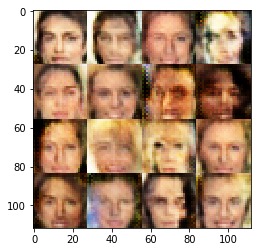

Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 1.1160... Generator Loss: 0.9096
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.1848... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.5386... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.7715
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.9555


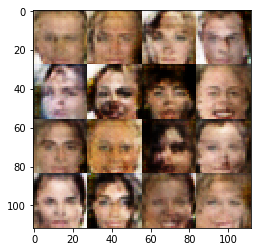

Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.4082
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.6021


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.